In [0]:
# QUESTIONS:
# no matter what classifier we are using: with the feature selection we don't want to 
# get a lot worse, not better (try tree on the selected features? or would this be
# redundant?)

# COMMENTS:
# order: put forest before tree, because we are actually using the number of features 
# suggested by the tree not by the forest 
# especially because of bootstrap, think about splitting of the data 
# we still need to compare the solutions to a tree trained on the whole train_set !

# Report

All together we need to have 4 pages, 2 of which need to be a written report and the rest are diagrams and images. The code needs to be in the appendix. 

In this machine learning project our aim was to do feature selection on biomedical data, which we found on kaggle. The features of the data consist of over 20,000 different genes. The values of the features are numerical. 

There are several feature selection methods, which can be grouped in embedded methods, filter methods and wrapped methods. In our project we focused on embedded methods, even though we also tried some filter methods. Embedded methods are algorithms that have an intrinsic feature selection, like for example random decision trees and random decision forests.  Once a random decision tree is built we can look at the feature score and check which features have been used and which have not. Even better the score also tells us how important the feature is in comparison to the others. 

Before we could start to implement a chosen feature selection method, we needed to choose a classifier to test the results we obtained by using feature selection. As we wanted to use random decision trees to select our features, we decided to use the K-nearest neighbors classifier to compare our results. At the beginning of the code we did a cross-validation to find out how many neighbors we need to use for the whole feature set to obtain the best accuracy score. Once we decided on a suitable feature subset we will do the same cross-validation to find out the optimal $K$ for the modified problem.  

We are going to evaluate the different results using  cross validation and the train, test and validation split.  

Our first attempt was to look at the feature scores of a random decision forest that consists of 100 weak decision trees. Roughly 3000 features have been used in total. 
IMAGE 
However our aim was to select still fewer features. That is why we decided to look at the features that have been chosen by single, but strong decision trees. On average those classifiers chose about 20 features from the given 20,000.  
IMAGE

features have not been the same
can we still get less than 20 features?
K nearest neighbor classifier to test

# Appendix
Needs to contain the clean code. 

In [0]:
from google.colab import files
from zipfile import ZipFile
from sklearn import (datasets, svm, tree, model_selection, linear_model, metrics, 
preprocessing, pipeline, feature_selection)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import chi2
from collections import Counter

import scipy.stats
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

In [0]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nasreenahmed","key":"84d6e93849aba924992e6ca3bd7c579d"}'}

In [0]:
!pip install -q kaggle

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [0]:
# download dataset
!kaggle datasets download -d murats/gene-expression-cancer-rnaseq

 92% 65.0M/70.6M [00:00<00:00, 73.5MB/s]
100% 70.6M/70.6M [00:00<00:00, 131MB/s] 


In [0]:
# extract the data from the zip file
zip_file = ZipFile('/content/gene-expression-cancer-rnaseq.zip')
fields = ['data', 'labels']
data_rna = pd.read_csv(zip_file.open('data.csv'))
labels_rna = pd.read_csv(zip_file.open('labels.csv'))

In [0]:
# we want to split our data into 3 parts: train, validation, test
# 3 parts so we can tune the hyper parameters with the validation set and 
# test everything on a set that has not been used before

# data and labels are np.arrays of the same size

def train_validate_test_split(data, labels, train_percent = .6, validate_percent = .2,
                              seed = None):
    # set seed so we are able to reproduce the split
    np.random.seed(seed)

    # shuffle the indices of the array
    n = data.shape[0]
    perm = np.random.permutation(n)
    train_end = int(train_percent * n)
    validation_end = int(validate_percent * n) + train_end

    train_data = data[perm[:train_end]]
    train_label = labels[perm[:train_end]]

    val_data = data[perm[train_end:validation_end]]
    val_label = labels[perm[train_end:validation_end]]

    test_data = data[perm[validation_end:]]
    test_label = labels[perm[validation_end:]]

    return train_data, train_label, val_data, val_label, test_data, test_label

In [0]:
# prepare the data

# 1. transform data into array
data = data_rna.values
labels = labels_rna.values

# 2. get rid of the name (sample xy)
# one row -> one sample
data = data[:,1:]
labels = labels[:,1:]

# 3. transform names of labels into numbers, t_labels is the new label variable
target_names, t_labels = np.unique(labels, return_inverse = True)

# 4. split data in train, val and test
train_data, train_labels, val_data, val_labels, test_data, test_labels = train_validate_test_split(data, t_labels)

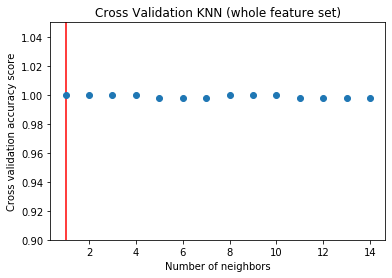

Cross validation accuracy score of KNN for k = 1 on the whole feature set: 1.000


In [0]:
# K nearest neighbors classifier 
# find out how many neighbors to use for the whole data set
mean_k = []
var_k = []
for k in range(1,15):
    clf = KNeighborsClassifier(n_neighbors=k)
    cross_val = model_selection.cross_val_score(clf, train_data, train_labels, cv = 5)
    mean_k.append(cross_val.mean())
    var_k.append(cross_val.var())

k_wholeset = np.argmax(mean_k) + 1
plt.figure()
plt.title('Cross Validation KNN (whole feature set)')
plt.xlabel('Number of neighbors')
plt.ylabel('Cross validation accuracy score')
plt.ylim(0.9,1.05)
plt.errorbar(range(1,15), mean_k, yerr = var_k, fmt = 'o')
plt.plot(k_wholeset * np.ones(50), np.linspace(0, 1.2), color = 'red')
plt.show()
print('Cross validation accuracy score of KNN for k = %d on the whole feature set: %.3f' %(k_wholeset, mean_k[k_wholeset-1]))

[2910, 13210, 14114, 1510, 19296, 13818, 11920, 17316, 18391, 17751, 9184, 18135, 8014, 450, 7992, 16377, 3737, 11713, 2774, 1846]


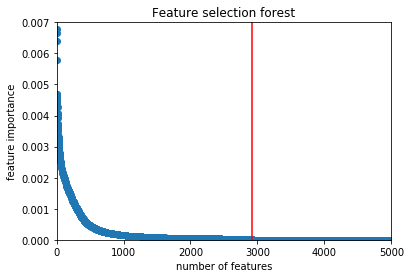

In [0]:
# feature selection using random decision forests (feature ranking) 
forest = ExtraTreesClassifier(n_estimators = 100, random_state = 0)
forest = forest.fit(train_data, train_labels)

importances = forest.feature_importances_
ind = np.argsort(importances)[::-1]

selected_features_forest = []
for f in range(train_data.shape[1]):
    if (importances[ind[f]] == 0):
        break
    selected_features_forest.append(ind[f])

plt.figure()
plt.title("Feature selection forest")
print(selected_features_forest[0:20])
plt.scatter(range(train_data.shape[1]), importances[ind])

# to show where the feature importances become 0 
plt.plot(np.ones(50)*len(selected_features_forest), np.linspace(0,1), 'k-', color = 'red')
plt.xlabel('number of features')
plt.ylabel('feature importance')
plt.xlim(0,5000)
plt.ylim(0, 0.007)
plt.show()

We want to try to reduce the number of features even further, that is why we are using strong single decision trees now. 

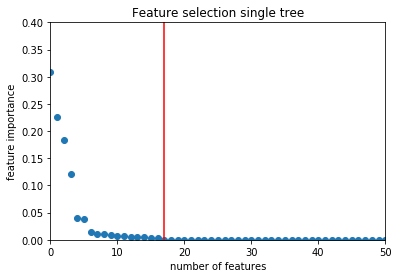

In [0]:
# random decision tree feature selection (feature ranking)
tree_clf = DecisionTreeClassifier(splitter = 'best', max_features='sqrt')
tree_clf = tree_clf.fit(train_data, train_labels)

importances = tree_clf.feature_importances_
ind = np.argsort(importances)[::-1]

selected_features_tree = []
for f in range(train_data.shape[1]):
    if (importances[ind[f]] == 0):
         break
    selected_features_tree.append(ind[f])

plt.figure()
plt.title('Feature selection single tree')
plt.scatter(range(train_data.shape[1]), importances[ind])
plt.plot(np.ones(50)*len(selected_features_tree), np.linspace(0,1), 'k-', color = 'red')
plt.xlabel('number of features')
plt.ylabel('feature importance')
plt.xlim(0,50)
plt.ylim(0,0.4)
plt.show()

We found out that the random decision tree does not always choose the same features. We run the code multiple times and then counted the number of times a feature was selected by the tree. We then chose a feature subset consisting of all the features that appeared in more than one tree. (Makes the subset a bit smaller than the average number of selected features by a single tree) 

In [0]:
# find out which features are chosen by a strong decision tree classifier
# train 20 strong decision tree classifier to find out which features are the 
# most important ones 

total_ft = []
total_means = []
for rep in range(20):
    features = []
    tree_clf = DecisionTreeClassifier(splitter = 'best', max_features = 'sqrt')
    tree_clf = tree_clf.fit(train_data, train_labels)

    importances = tree_clf.feature_importances_
    ind = np.argsort(importances)[::-1]

    for f in range(train_data.shape[1]):
        if (importances[ind[f]] == 0):
            break
        # with features i just want to know how many features are important
        # can probably solved in a better way    
        features.append(ind[f])
        total_ft.append(ind[f])

    total_means.append(len(features))

# Show which feature was selected how often
feat_information = Counter(total_ft)

In [0]:
# we need to collect the features that have been chosen more than once 
feat_dict = dict(feat_information)
feat_list = list(feat_information)
nb_feat = int(np.mean(total_means))

features_tree = []
for i in feat_list:
    if (feat_dict[i] > 1):
        features_tree.append(i)

# can be improved as well         
print('The subset consists of %d features, which occured in more than one tree' %len(features_tree))

The subset consists of 14 features, which occured in more than one tree


In [0]:
# set the subset train data 
train_data_subset = train_data[:, features_tree]


Sequential Forward Selection (k=10):
(0, 1, 3, 4, 5, 6, 8, 11, 12, 13)
CV Score:
0.9979166666666667


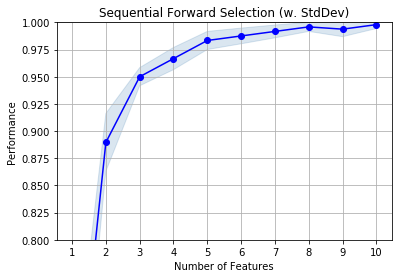


Sequential Backward Selection (k=10):
(0, 1, 2, 3, 4, 5, 8, 11, 12, 13)
CV Score:
0.9958333333333333


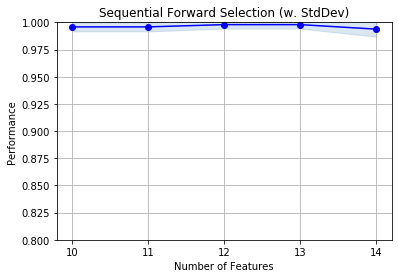

In [0]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

# Sequential Forward Selection
sfs = SFS(RandomForestClassifier(), 
          k_features=10, 
          forward=True, 
          floating=False, 
          scoring='accuracy',
          cv=4,
          n_jobs=-1)
sfs = sfs.fit(train_data_subset,train_labels)

print('\nSequential Forward Selection (k=10):')
print(sfs.k_feature_idx_)
print('CV Score:')
print(sfs.k_score_)

fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.ylim([0.8, 1])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()
###################################################

# Sequential Backward Selection
sbs = SFS(RandomForestClassifier(), 
          k_features=10, 
          forward=False, 
          floating=False, 
          scoring='accuracy',
          cv=4,
          n_jobs=-1)
sbs = sbs.fit(train_data_subset,train_labels)

print('\nSequential Backward Selection (k=10):')
print(sbs.k_feature_idx_)
print('CV Score:')
print(sbs.k_score_)

fig1 = plot_sfs(sbs.get_metric_dict(), kind='std_dev')

plt.ylim([0.8, 1])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

In [0]:
# Extracting the index for forward selection 
sfs_feature_list = np.array(sfs.k_feature_idx_)
res_list_sfs = [features_tree[i] for i in sfs_feature_list]
train_data_subset_sfs = train_data[:, res_list_sfs]

# Extracting the index for backward elimination
sfs_feature_list = np.array(sbs.k_feature_idx_)
res_list_sbs = [features_tree[i] for i in sfs_feature_list]
train_data_subset_sbs = train_data[:, res_list_sbs]

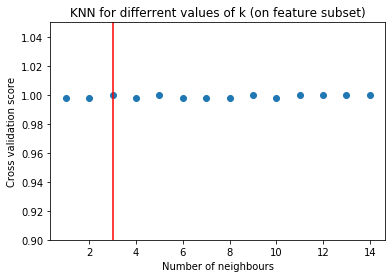

Cross validation accuracy score of KNN for k = 3 on the feature subset: 1.000


In [0]:
# test the classifier with cross validation for each iteration
# check this again
mean_list_k = []
for k in range(1,15):
    clf = KNeighborsClassifier(n_neighbors=k)
    cross_val = model_selection.cross_val_score(clf, train_data_subset, train_labels, cv = 5)
    mean_list_k.append(cross_val.mean())

k_subset = np.argmax(mean_list_k) + 1
plt.scatter(range(1,15), mean_list_k)
plt.plot(k_subset * np.ones(50), np.linspace(0,1.2), color = 'red')
plt.title('KNN for differrent values of k (on feature subset)')
plt.xlabel('Number of neighbours')
plt.ylabel('Cross validation score')
plt.ylim(0.9,1.05)
plt.show()

print('Cross validation accuracy score of KNN for k = %d on the feature subset: %.3f' %(k_subset, mean_list_k[k_subset-1]))

In [0]:
# Checking the accuray of the forward selection feature selection method
knn_allfeatures = KNeighborsClassifier(n_neighbors=k_wholeset)
knn_allfeatures = knn_allfeatures.fit(train_data, train_labels)
pred_all = knn_allfeatures.predict(val_data)
score_all = metrics.accuracy_score(val_labels, pred_all)
print('The KNN classifier trained on the whole feature set gives an accuracy of %.3f' %score_all)

# Accuray of the forward selection feature selection method
knn_reduced = KNeighborsClassifier(n_neighbors=k_subset)
knn_reduced = knn_reduced.fit(train_data_subset_sfs, train_labels)
pred_reduced = knn_reduced.predict(val_data[:, res_list_sfs])
score_reduced = metrics.accuracy_score(val_labels, pred_reduced)
print('The KNN classifier trained on the feature subset obtained from forward selection of size %d gives an accuracy of %.3f' %(len(res_list_sfs), score_reduced))

# Accuray of the Backward Eliminationfeature selection method
knn_reduced = KNeighborsClassifier(n_neighbors=k_subset)
knn_reduced = knn_reduced.fit(train_data_subset_sbs, train_labels)
pred_reduced = knn_reduced.predict(val_data[:, res_list_sbs])
score_reduced = metrics.accuracy_score(val_labels, pred_reduced)
print('The KNN classifier trained on the feature subset obtained from backward elimination of size %d gives an accuracy of %.3f' %(len(res_list_sbs), score_reduced))

The KNN classifier trained on the whole feature set gives an accuracy of 0.994
The KNN classifier trained on the feature subset obtained from forward selection of size 10 gives an accuracy of 0.975
The KNN classifier trained on the feature subset obtained from backward elimination of size 10 gives an accuracy of 0.981


Before getting rid of even more features check the accuracy of the subset in comparison to the whole feature set. 

In [0]:
knn_allfeatures = KNeighborsClassifier(n_neighbors=k_wholeset)
knn_allfeatures = knn_allfeatures.fit(train_data, train_labels)
pred_all = knn_allfeatures.predict(val_data)
score_all = metrics.accuracy_score(val_labels, pred_all)
print('The KNN classifier trained on the whole feature set gives an accuracy of %.3f' %score_all)

knn_reduced = KNeighborsClassifier(n_neighbors=k_subset)
knn_reduced = knn_reduced.fit(train_data_subset, train_labels)
pred_reduced = knn_reduced.predict(val_data[:, features_tree])
score_reduced = metrics.accuracy_score(val_labels, pred_reduced)
print('The KNN classifier trained on the feature subset of size %d gives an accuracy of %.3f' %(len(features_tree), score_reduced))

The KNN classifier trained on the whole feature set gives an accuracy of 0.994
The KNN classifier trained on the feature subset of size 14 gives an accuracy of 0.969


We have now reduced the number of features from more than 20,000 to about 20. However we want to know whether we can possibly reduce the features even more without loosing too much accuracy. Now we are using filter methods like pearson correlation and chi2 score to find out whether all of the 20 features are relevant.  

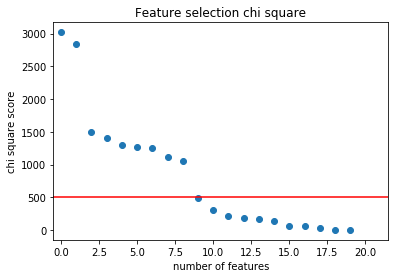

In [0]:
# try to reduce the features we have selected from the tree by comparing 
# their chi squared scores 
# we compute the chi square value for each feature
# we only want to include features that have a high score
# we want to find out the features for which the class is highly dependant on its 
# occurence
# the higher the chi squre score, the more dependant are the two events
# so we only want to include features in the model, which have a high score

chi_features = chi2(train_data_subset, train_labels)[0]
selected_features_chi_score = np.argsort(chi_features)[::-1]
chi_values = np.sort(chi_features)[::-1]

plt.title('Feature selection chi square')
plt.xlabel('number of features')
plt.ylabel('chi square score')
plt.plot(np.linspace(-1,len(chi_features)+1), 500*np.ones(50), color = 'red')
plt.xlim(-0.5, len(chi_features)+0.5)
plt.scatter(np.arange(0,chi_plot.shape[0]),chi_plot)
plt.show()

We can see that the chi squared values are torn apart. That is why we assume it is justified to try to cut the features that have a chi 2 score lower than 500 (there is a gap). 

In [0]:
# only use those features who have a higher chi2 score than 500 
features_chi2 = []
for i in range(len(features_tree)):
    if (chi_features[i] >= 500):
        features_chi2.append(features_tree[i])

In [0]:
train_data_chi2_subset = train_data[:, features_chi2]
knn_chi2 = KNeighborsClassifier(n_neighbors=k_subset)
knn_chi2 = knn_chi2.fit(train_data_chi2_subset, train_labels)
pred = knn_chi2.predict(val_data[:,features_chi2])
score_chi2 = metrics.accuracy_score(val_labels, pred)

print('The KNN classifier on a subset of size %d gives an accuracy of %.3f' %(len(features_chi2), score_chi2))

The KNN classifier on a subset of size 12 gives an accuracy of 0.994


Check whether some of the remaining features are correlated. However as we only have 9 features left, I decided to only delete a feature if it's very strongly correlated to another one (meaning in this case the absolute value of the score is higher than 0.75). 

In [0]:
features = []
pearson_mat = np.zeros((len(features_chi2), len(features_chi2)))
for i in range(len(features_chi2)):
    for j in range(len(features_chi2)):
        pearson_score = scipy.stats.pearsonr(train_data_chi2_subset[:,i]
                                             , train_data_chi2_subset[:,j])[0]
        pearson_mat[i,j] = pearson_score
        if (pearson_score > .75 and i > j):
            features.append([i,j])

print('|Pearson score| > 0.75 \n')
print(np.abs(pearson_mat) > 0.75)

|Pearson score| > 0.75 

[[ True False False False False False False False False False False False]
 [False  True False False False False False  True False False False False]
 [False False  True False False False False False False False False False]
 [False False False  True False False False False False False False False]
 [False False False False  True False False False False False False False]
 [False False False False False  True  True False False False False False]
 [False False False False False  True  True False False False False False]
 [False  True False False False False False  True False False False False]
 [False False False False False False False False  True False False False]
 [False False False False False False False False False  True False False]
 [False False False False False False False False False False  True False]
 [False False False False False False False False False False False  True]]


Delete one of the strongly correlated features


In [0]:
features_pearson = []
remove_index = []
for i in range(len(features)):
    remove_index.append(features[i][0])

for i in range(len(features_chi2)):
    if (i in remove_index):
        continue
    features_pearson.append(features_chi2[i])

10


In [0]:
knn_pearson = KNeighborsClassifier(n_neighbors=k_subset)
knn_pearson = knn_pearson.fit(train_data[:,features_pearson], train_labels)
pred = knn_pearson.predict(val_data[:, features_pearson])
pearson_score = metrics.accuracy_score(val_labels, pred)
print('The KNN classfier on a feature subset of size %d gives an accuracy of %.3f' %(len(features_pearson), pearson_score))

The KNN classfier on a subset of size 10 gives an accuracy of 0.988


Final accuracy check on the test data this time (careful, only test with test set in the end) 

In [0]:
print('Final test on test data \n')

pred = knn_allfeatures.predict(test_data)
all_score = metrics.accuracy_score(test_labels, pred)
print('The KNN classifier on the whole subset gives accuracy of %.3f' %all_score)

pred = knn_reduced.predict(test_data[:, features_tree])
tree_score = metrics.accuracy_score(test_labels, pred)
print('The KNN classifier on feature subset of size %d gives accuracy of %.3f' %(len(features_tree), tree_score))

pred = knn_chi2.predict(test_data[:, features_chi2])
chi2_score = metrics.accuracy_score(test_labels, pred)
print('The KNN classifier on feature subset of size %d gives accuracy of %.3f' %(len(features_chi2), chi2_score))

pred = knn_pearson.predict(test_data[:, features_pearson])
pearson_score = metrics.accuracy_score(test_labels, pred)
print('The KNN classifier on feature subset of size %d gives accuracy of %.3f' %(len(features_pearson), pearson_score))

Final test on test data 

The KNN classifier on the whole subset gives accuracy of 1.000
The KNN classifier on feature subset of size 21 gives accuracy of 0.981
The KNN classifier on feature subset of size 12 gives accuracy of 0.975
The KNN classifier on feature subset of size 10 gives accuracy of 0.969
